In [3]:
# Uploading the packages we'll need
import os
from zipfile import ZipFile
import pickle
import bz2
import json

import numpy.testing as npt

import pandas as pd
import numpy as np

import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt


2021-12-15 12:01:47.133560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# expected file paths
DATA_ROOT_DIRECTORY: str = 'data'
COMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'compressed')
COMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_manifest.pbz2')
COMPRESSED_IMAGES_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_images.zip')

# file paths to createhttp://localhost:8888/notebooks/Documents/EN213_final/EM213-Final_Project-dev-kms/Ship%20Analysis.ipynb
UNCOMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'uncompressed')
UNCOMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet.json')
UNCOMPRESSED_IMAGES_DIRECTORY_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet')
    
def get_full_path(local_path: str):
    """
    Gets the full path from the local path.

    :param local_path: a string pointing to a path local to this Notebook
    :returns: a string pointing to the full path corresponding to the provided local path
    """
    return os.path.join(os.getcwd(), local_path)

def raise_file_not_found_error_for_path(expected_object: str, local_path: str):
    """
    Raises a descriptive file not found error using the provided

    :param expected_object: a string fragment describing the content of the expected file
    :param local_path: the path that was not found
    :return: None.
    :raises FileNotFoundError
    """
    raise FileNotFoundError(f'Could not find {expected_object} at the specified path: {get_full_path(local_path)}')

In [5]:
def deflate_manifest():
    """
    Deflates the compressed manifest file using bz2 decompression. Note this will create a ~350 MB file in the
    UNCOMPRESSED_DATA_DIRECTORY_PATH.

    :return: None.
    """
    with bz2.BZ2File(COMPRESSED_MANIFEST_FILE_PATH, 'rb') as input_file:
        with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'w') as output_file:
            json.dump(pickle.load(input_file), output_file)
    return None


def deflate_images():
    """
    Deflates the compressed images file using zip decompression. Note this will create 4000 images in the
    UNCOMPRESSED_IMAGES_DIRECTORY_PATH directory.

    :return: None.
    """
    with ZipFile(COMPRESSED_IMAGES_FILE_PATH, 'r') as input_file:
        input_file.extractall(UNCOMPRESSED_IMAGES_DIRECTORY_PATH)
    return None


def check_and_deflate_all():
    """
    Checks for expected input files and a non-existent UNCOMPRESSED_DATA_DIRECTORY_PATH directory, then
    deflates the manifest and images. 

    :raises FileNotFoundError if expected input files are not found
    :raises FileExistsError if UNCOMPRESSED_DATA_DIRECTORY_PATH exists
    :returns: None.
    """

    # check if compressed data directory exists
    if os.path.isdir(COMPRESSED_DATA_DIRECTORY_PATH):

        # if so, check for compressed manifest file
        if not os.path.isfile(COMPRESSED_MANIFEST_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed manifest file', COMPRESSED_MANIFEST_FILE_PATH)

        # and compressed images file
        if not os.path.isfile(COMPRESSED_IMAGES_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed images file', COMPRESSED_IMAGES_FILE_PATH)

    else:
        raise raise_file_not_found_error_for_path('the compressed data directory', COMPRESSED_DATA_DIRECTORY_PATH)

    # check if uncompressed data directory exists
    if os.path.isdir(UNCOMPRESSED_DATA_DIRECTORY_PATH):
        raise FileExistsError(('The path to the output directory already exists: '
                               f'{get_full_path(UNCOMPRESSED_DATA_DIRECTORY_PATH)}. If you are sure you want to run this step '
                               'please remove this directory manually - we will not overwrite it.'))

    # inflate files
    else:
        os.mkdir(UNCOMPRESSED_DATA_DIRECTORY_PATH)
        deflate_manifest()
        deflate_images()

    return None

In [6]:
check_and_deflate_all()

FileExistsError: The path to the output directory already exists: /home/colinalejo/Documents/EN213_final/HOG/data/uncompressed. If you are sure you want to run this step please remove this directory manually - we will not overwrite it.

In [15]:
# read in the manifest
with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'r') as f:
    dataset = json.load(f)



In [16]:
# Turning the json information into a numpy array and then assign it as our X and y values

X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

# Checking the amount of ship and not a ship labels for the images

pd.Series(y).value_counts()

0    3000
1    1000
dtype: int64

In [17]:
img_length = 80
X_reshaped = X.reshape([-1, 3, img_length, img_length]).transpose([0,2,3,1])
y_reshaped = to_categorical(y, num_classes=2)
#normlaize
X_reshaped = X_reshaped / 255


## Apply RGB2Gray!!

In [18]:
from skimage import color
from skimage.feature import hog
from skimage.transform import resize

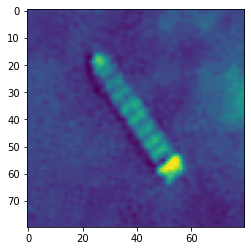

In [19]:
data_gray = [ color.rgb2gray(i) for i in X_reshaped ]
data_gray = np.array(data_gray)
plt.imshow(data_gray[1])

In [20]:
data_gray.shape

(4000, 80, 80)

## Apply HOG!!

In [21]:
ppc = 16
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [22]:
hog_images = np.array(hog_images)
hog_features = np.array(hog_features)
                 
                 

In [23]:
hog_images.shape

(4000, 80, 80)

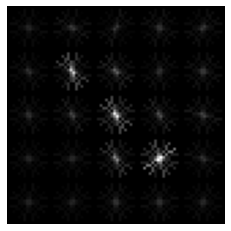

In [24]:
plt.axis("off")
plt.imshow(hog_images[1], cmap="gray")

## Implement Hog and RGB images with KERAS to compare

In [25]:
#HOG
# Doing the initial train/test split on the reshaped values
hog_X_train_full, hog_X_test, hog_y_train_full, hog_y_test = train_test_split(hog_images, y_reshaped, test_size=0.20, random_state=42)

# Creating the validation set
hog_X_train, hog_X_val, hog_y_train, hog_y_val = train_test_split(hog_X_train_full, hog_y_train_full, test_size=0.25, random_state=42)


#RGB
# Doing the initial train/test split on the reshaped values
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.20, random_state=42)

# Creating the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [26]:
hog_y_train.shape

(2400, 2)

In [27]:
hog_X_test  = hog_X_test.reshape(-1, 80, 80, 1)
hog_X_train = hog_X_train.reshape(-1, 80, 80, 1)
hog_X_val   = hog_X_val.reshape(-1, 80, 80, 1)

In [28]:
hog_X_train.shape

(2400, 80, 80, 1)

##### First model with Hog

In [29]:
# Using a 5x5 kernel and a pooling size of 3x3 at the start of the sequence

# Increasing the number of nodes in the first convolution layer 

# Increasing the pool size in the first pool layer

# Adding an extra convolutional layer + drop out layers to prevent over fitting

# Adding an extra dense layer of 50 neurons towards the end

# Increasing the epochs to 50

# Setting my computer on fire

hog_model = Sequential()
hog_model.add(Conv2D(64, (5, 5), input_shape=(80, 80,1), activation='relu')) #remove rgb 3 matrix
hog_model.add(MaxPooling2D(pool_size=(3, 3)))
hog_model.add(Dropout(0.25))
hog_model.add(Conv2D(32, (3, 3), input_shape=(80, 80,1), activation='relu')) #remove rgb 3 matrix
hog_model.add(MaxPooling2D(pool_size=(2, 2)))
hog_model.add(Dropout(0.25))
hog_model.add(Conv2D(32, (3, 3), input_shape=(80, 80,1), activation='relu')) #remove rgb 3 matrix
hog_model.add(MaxPooling2D(pool_size=(2, 2)))
hog_model.add(Flatten())
hog_model.add(Dense(100, activation='relu'))
hog_model.add(Dropout(0.25))
hog_model.add(Dense(100, activation='relu'))
hog_model.add(Dropout(0.25))
hog_model.add(Dense(50, activation='relu'))
hog_model.add(Dropout(0.25))
hog_model.add(Dense(2, activation='softmax'))

hog_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])



In [30]:
# Training the model

hog_history = hog_model.fit(hog_X_train, hog_y_train, epochs=50, validation_data=(hog_X_val, hog_y_val))

2021-12-15 12:02:42.970743: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-15 12:02:42.987851: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/50
75/75 [==============================] - 8s 103ms/step - loss: 0.5988 - accuracy: 0.7538 - val_loss: 0.5267 - val_accuracy: 0.7513
Epoch 2/50
75/75 [==============================] - 8s 102ms/step - loss: 0.4151 - accuracy: 0.7888 - val_loss: 0.2556 - val_accuracy: 0.8775
Epoch 3/50
75/75 [==============================] - 7s 99ms/step - loss: 0.2177 - accuracy: 0.9116 - val_loss: 0.2228 - val_accuracy: 0.8788
Epoch 4/50
75/75 [==============================] - 8s 111ms/step - loss: 0.1797 - accuracy: 0.9172 - val_loss: 0.1962 - val_accuracy: 0.9200
Epoch 5/50
75/75 [==============================] - 7s 97ms/step - loss: 0.1568 - accuracy: 0.9330 - val_loss: 0.2199 - val_accuracy: 0.9275
Epoch 6/50
75/75 [==============================] - 7s 95ms/step - loss: 0.1557 - accuracy: 0.9426 - val_loss: 0.1320 - val_accuracy: 0.9525
Epoch 7/50
75/75 [==============================] - 7s 96ms/step - loss: 0.1167 - accuracy: 0.9570 - val_loss: 0.1217 - val_accuracy: 0.9500
Epoch 8/50

##### First model with RGB images

In [31]:
# Using a 5x5 kernel and a pooling size of 3x3 at the start of the sequence

# Increasing the number of nodes in the first convolution layer 

# Increasing the pool size in the first pool layer

# Adding an extra convolutional layer + drop out layers to prevent over fitting

# Adding an extra dense layer of 50 neurons towards the end

# Increasing the epochs to 50

# Setting my computer on fire

model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [32]:
# Training the model

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
75/75 [==============================] - 10s 121ms/step - loss: 0.5523 - accuracy: 0.7704 - val_loss: 0.3955 - val_accuracy: 0.8725
Epoch 2/50
75/75 [==============================] - 9s 117ms/step - loss: 0.3408 - accuracy: 0.8487 - val_loss: 0.2198 - val_accuracy: 0.9150
Epoch 3/50
75/75 [==============================] - 9s 117ms/step - loss: 0.2376 - accuracy: 0.9102 - val_loss: 0.2118 - val_accuracy: 0.9075
Epoch 4/50
75/75 [==============================] - 9s 115ms/step - loss: 0.1973 - accuracy: 0.9123 - val_loss: 0.2060 - val_accuracy: 0.9275
Epoch 5/50
75/75 [==============================] - 9s 116ms/step - loss: 0.1831 - accuracy: 0.9262 - val_loss: 0.1776 - val_accuracy: 0.9325
Epoch 6/50
75/75 [==============================] - 9s 116ms/step - loss: 0.1529 - accuracy: 0.9341 - val_loss: 0.1712 - val_accuracy: 0.9375
Epoch 7/50
75/75 [==============================] - 9s 115ms/step - loss: 0.1523 - accuracy: 0.9364 - val_loss: 0.1819 - val_accuracy: 0.9413
Epoch

## Compare RGB vs HOG

##### It seems like hog has lower loss!!!!

In [34]:
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 27ms/step - loss: 0.0961 - accuracy: 0.9862


[0.0960763618350029, 0.9862499833106995]

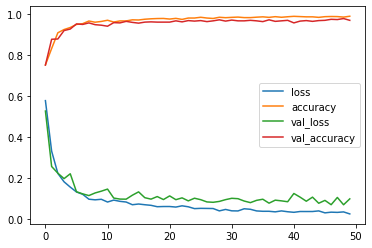

In [35]:
pd.DataFrame(hog_history.history).plot();

In [36]:
hog_model.evaluate(hog_X_test, hog_y_test)

25/25 [==============================] - 1s 22ms/step - loss: 0.0425 - accuracy: 0.9800


[0.04250335320830345, 0.9800000190734863]

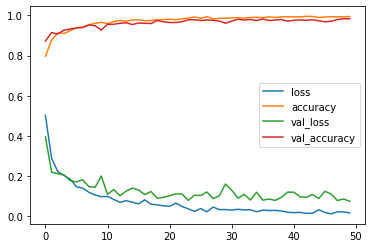

In [37]:
pd.DataFrame(history.history).plot();

In [38]:
model.save('cnn_models/rgb_model')

2021-12-15 12:17:04.881320: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cnn_models/rgb_model/assets


In [39]:
hog_model.save('cnn_models/hog_model')

INFO:tensorflow:Assets written to: cnn_models/hog_model/assets
